# 线性回归的从零开始实现

在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的。因此，本节将介绍如何只利用 NDArray 和`autograd`来实现一个线性回归的训练。

首先，导入本节中实验所需的包或模块，其中的 matplotlib 包可用于作图，且设置成嵌入显示。

In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

## 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为 1000，输入个数（特征数）为 2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪音项 $\epsilon$ 来生成标签

$$\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon,$$

其中噪音项 $\epsilon$ 服从均值为 0 和标准差为 0.01 的正态分布。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

注意到`features`的每一行是一个长度为 2 的向量，而`labels`的每一行是一个长度为 1 的向量（标量）。

In [3]:
features[0], labels[0]

(
 [ 1.16307855  0.48380461]
 <NDArray 2 @cpu(0)>, 
 [ 4.87962484]
 <NDArray 1 @cpu(0)>)

通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，我们可以更直观地观察两者间的线性关系。

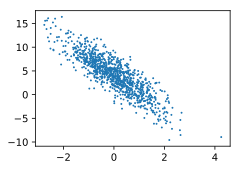

In [4]:
def use_svg_display():
    # 用矢量图显示。
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸。
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);

我们将上面的`plt`作图函数以及`use_svg_display`和`set_figsize`函数定义在`gluonbook`包里。以后在作图时，我们将直接调用`gluonbook.plt`。由于`plt`在`gluonbook`包中是一个全局变量，我们在作图前只需要调用`gluonbook.set_figsize()`即可打印矢量图并设置图的尺寸。


## 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [5]:
# 本函数已保存在 gluonbook 包中方便以后使用。
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的。
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take 函数根据索引返回对应元素。

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为（10， 2），分别对应批量大小和输入个数；标签形状为批量大小。

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[ -6.57035172e-01  -7.01076090e-01]
 [  2.39253566e-01   7.06367135e-01]
 [  2.96700746e-01   1.31119514e+00]
 [  1.01752184e-01   1.05692983e+00]
 [  1.91104501e-01  -1.50072062e+00]
 [ -5.42003720e-04  -4.72701073e-01]
 [ -9.18563426e-01  -7.45714366e-01]
 [ -1.72665939e-01  -1.19168591e+00]
 [  2.77956992e-01   1.12194681e+00]
 [ -2.79737622e-01   7.49515966e-02]]
<NDArray 10x2 @cpu(0)> 
[ 5.27555895  2.28396082  0.34051183  0.80621552  9.68376541  5.80794668
  4.90824556  7.91727114  0.94736618  3.38924193]
<NDArray 10 @cpu(0)>


## 初始化模型参数

我们将权重初始化成均值为 0 标准差为 0.01 的正态随机数，偏差则初始化成 0。

In [7]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

之后的模型训练中，我们需要对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度。

In [8]:
w.attach_grad()
b.attach_grad()

## 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`dot`函数做矩阵乘法。

In [9]:
def linreg(X, w, b):  # 本函数已保存在 gluonbook 包中方便以后使用。
    return nd.dot(X, w) + b

## 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [10]:
def squared_loss(y_hat, y):  # 本函数已保存在 gluonbook 包中方便以后使用。
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [11]:
def sgd(params, lr, batch_size):  # 本函数已保存在 gluonbook 包中方便以后使用。
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为 10，每个小批量的损失`l`的形状为（10，1）。回忆一下[“自动求梯度”](../chapter_prerequisite/autograd.md)一节。由于变量`l`并不是一个标量，运行`l.backward()`将对`l`中元素求和得到新的变量，再求该变量有关模型参数的梯度。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设 3 和 0.03。在实践中，大多超参数都需要通过反复试错来不断调节。当迭代周期数设的越大时，虽然模型可能更有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要 num_epochs 个迭代周期。
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X 和 y 分别是小批量样本的特征和标签。
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l 是有关小批量 X 和 y 的损失。
        l.backward()  # 小批量的损失对模型参数求梯度。
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数。
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.034885
epoch 2, loss 0.000121
epoch 3, loss 0.000048


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [13]:
true_w, w

([2, -3.4], 
 [[ 1.99983895]
  [-3.3999455 ]]
 <NDArray 2x1 @cpu(0)>)

In [14]:
true_b, b

(4.2, 
 [ 4.20005322]
 <NDArray 1 @cpu(0)>)

## 小结

* 可以看出，仅使用 NDArray 和`autograd`就可以很容易地实现一个模型。在接下来的章节中，我们会在此基础上描述更多深度学习模型，并介绍怎样使用更简洁的代码（例如下一节）来实现它们。


## 练习

* 为什么`squared_loss`函数中需要使用`reshape`函数？
* 尝试使用不同的学习率，观察损失函数值的下降快慢。
* 如果样本个数不能被批量大小整除，`data_iter`函数的行为会有什么变化？


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/743)

![](../img/qr_linear-regression-scratch.svg)

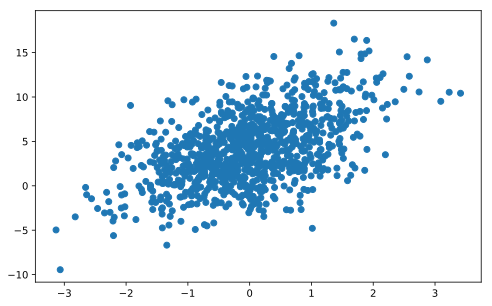

In [59]:
%matplotlib inline
from IPython import  display
from matplotlib import pyplot as plt
from mxnet import nd,autograd
import random

features = nd.random.normal(scale=1,shape=(1000,2))
true_w = nd.array([2,-3.4])
true_b = 4.2
labels = nd.dot(features,true_w.T)+ true_b
labels.reshape(1000,1)
labels+= nd.random.normal(scale=0.01,shape=labels.shape)
labels.reshape(1000,1)

display.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize']=(8,5)
plt.scatter((features[:,0]).asnumpy(),labels.asnumpy())

def linreg(X, w, b):  
    return nd.dot(X, w) + b

In [68]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i+batch_size,num_examples)])
        yield( features.take(j),labels.take(j) )
for X,y in data_iter(10,features,labels):
    #rint(X,y)
    break

w = nd.random.normal(scale=0.01,shape=(2,1))
b = nd.zeros(shape=(1))

w.attach_grad()
b.attach_grad()


def linreg(X, w, b):  
    return nd.dot(X, w) + b

def squared_loss(y_hat, y):  # 本函数已保存在 gluonbook 包中方便以后使用。
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
def sgd(params,lr,batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size
            
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss
batch_size = 10
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        with autograd.record():
            the_loss = loss(net(X,w,b),y)
        the_loss.backward()
        sgd([w,b],lr,batch_size)
    train_l = loss(net(features,w,b),labels)
    print(train_l.shape)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))
        


(1000, 1)
epoch 1, loss 2.259063
(1000, 1)
epoch 2, loss 0.313587
(1000, 1)
epoch 3, loss 0.043548
(1000, 1)
epoch 4, loss 0.006104
(1000, 1)
epoch 5, loss 0.000894
(1000, 1)
epoch 6, loss 0.000172
(1000, 1)
epoch 7, loss 0.000070
(1000, 1)
epoch 8, loss 0.000056
(1000, 1)
epoch 9, loss 0.000054
(1000, 1)
epoch 10, loss 0.000054
